In [ ]:
!python --version


Python 3.9.16


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import tensorflow as tf
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications import VGG16, InceptionResNetV2

import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import seaborn as sns
from pathlib import Path

from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

import keras
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras import regularizers
from keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.7 MB/s eta 0:00:00


In [ ]:
pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/jangedoo/utkface-new/code?datasetId=44109&sortBy=voteCount")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: weiya818
Your Kaggle Key: ··········


100%|██████████| 331M/331M [00:08<00:00, 39.2MB/s]


In [ ]:
#Codes cited from EECE571T Assignment3 
def dict_to_device(orig, device):
    new = {}
    for k,v in orig.items():
        new[k] = v.to(device)
    return new

def move_to_cuda(x):
  x_cuda = tuple([torch.from_numpy(arr).cuda() for arr in x])
  return x_cuda

def gray_to_color(x):
    return x.repeat(3, 1, 1)

def plot_images(img, ax):
    grid_img = torchvision.utils.make_grid(img)
    npimg = grid_img.numpy()
    
    if npimg.shape[0] == 3:
        npimg = np.transpose(npimg, (1, 2, 0))
    ax.imshow(npimg)
    ax.axis('off')
    

In [ ]:
def tuple_to_dict(batch_tuple):
    batch_dict = {}
    batch_dict['image'] = torch.tensor(batch_tuple[0])
    batch_dict['age'] = torch.tensor(batch_tuple[1])
    return batch_dict

def tuple_to_dict_multitask(batch_tuple):
    batch_dict = {}
    batch_dict['image'] = torch.tensor(batch_tuple[0])
    batch_dict['age'] = torch.tensor(batch_tuple[1][0])
    batch_dict['race'] = torch.tensor(batch_tuple[1][1])
    batch_dict['gender'] = torch.tensor(batch_tuple[1][2])
    return batch_dict

In [ ]:
data_dir = "/content/utkface-new/UTKFace" 
files = os.listdir(data_dir)
size = len(files)
print(size)
img_size=64

23708


In [ ]:
path = Path("/content/utkface-new/UTKFace")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))

image_path = []
ages = []
genders = []
races= []

np.random.seed(10)
np.random.shuffle(filenames)

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    ages.append(temp[0])
    genders.append(temp[1])
    try:
      races.append(int(temp[2]))
    except:
      races.append(4)

print(len(filenames))
print(filenames[:1])

23708
['50_0_3_20170119204347415.jpg.chip.jpg']


In [ ]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'], df['race'] = image_path, ages, genders, races
df

,image,age,gender,race
0,50_0_3_20170119204347415.jpg.chip.jpg,50,0,3
1,70_0_0_20170117173731439.jpg.chip.jpg,70,0,0
2,40_0_2_20170116222954442.jpg.chip.jpg,40,0,2
3,70_0_0_20170116233001019.jpg.chip.jpg,70,0,0
4,54_0_0_20170113210127075.jpg.chip.jpg,54,0,0
...,...,...,...,...
23703,28_1_4_20170117202452072.jpg.chip.jpg,28,1,4
23704,27_0_0_20170117175803620.jpg.chip.jpg,27,0,0
23705,8_1_1_20170116153005352.jpg.chip.jpg,8,1,1
23706,8_1_0_20170109203429413.jpg.chip.jpg,8,1,0


In [ ]:
gender_dict = {0:"Male",1:"Female"}
race_dict = {0:"White",1:"Black",2:"Asian",3:"Indian",4:"Others"}
df = df.astype({'age':'float32', 'gender': 'int32', 'race': 'int32'})

<ipython-input-13-9676526cf78c>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.age,kde=True, bins=30)


<Axes: xlabel='age', ylabel='Density'>

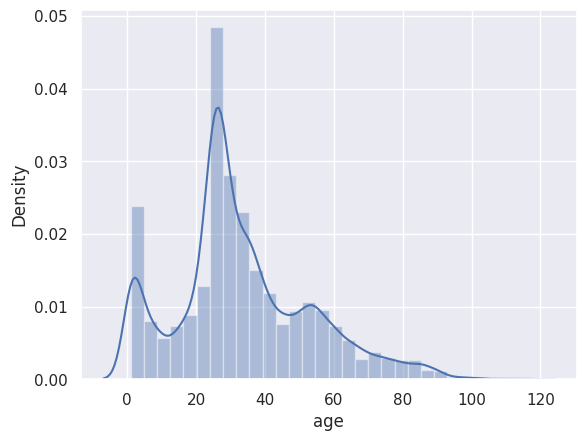

In [ ]:
sns.set_theme()
sns.distplot(df.age,kde=True, bins=30)

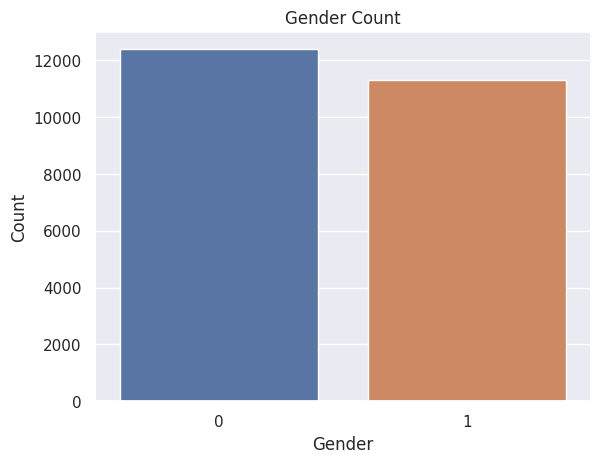

In [ ]:
sns.countplot(x='gender', data=df)
plt.title('Gender Count')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

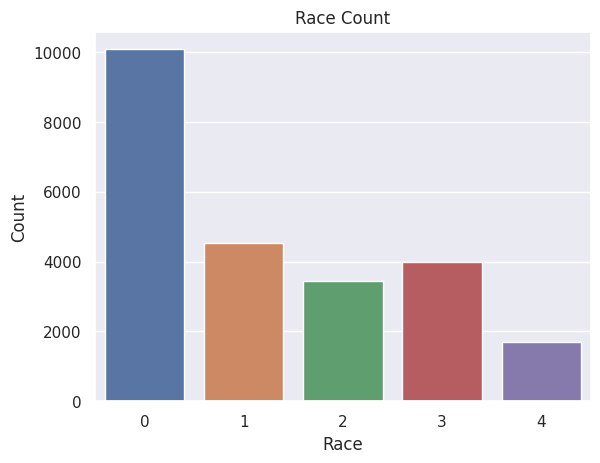

In [ ]:
sns.countplot(x='race', data=df)
plt.title('Race Count')
plt.xlabel('Race')
plt.ylabel('Count')
plt.show()

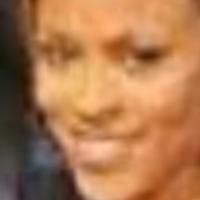

54.0
0
0


In [ ]:
# Define the file path of the image
image_file_path = "/content/utkface-new/UTKFace/"
image = Image.open(image_file_path +df.image[4])
image.show()
print(df.age[4])
print(df.gender[4])
print(df.race[4])

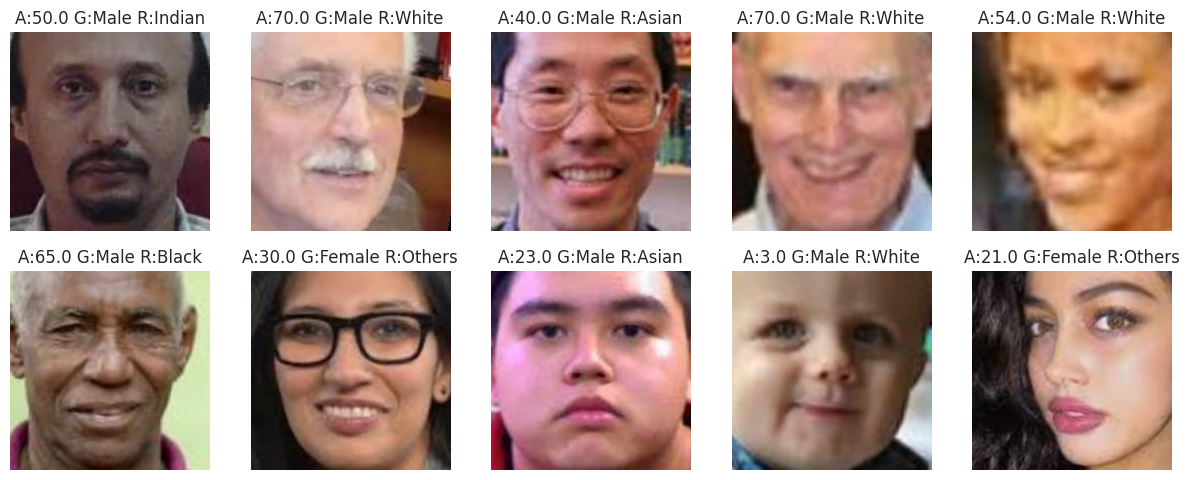

In [ ]:
plt.figure(figsize=(15,15))
files = df.iloc[0:10]

for index, image_file, age, gender, race in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img("/content/utkface-new/UTKFace/"+image_file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"A:{age} G:{gender_dict[gender]} R:{race_dict[race]}")
    plt.axis('off')

In [ ]:
x = []
for i in range(len(df)):
    file = df['image'].iloc[i]
  
    img = load_img("/content/utkface-new/UTKFace/"+file)
    img = img.resize((64,64), Image.ANTIALIAS)
    img = np.array(img)
    x.append(img)

x = np.array(x)
x = x.reshape(len(x), 64, 64, 3)

In [ ]:
y_age = df['age']
y_gender = df['gender']
y_race = df['race']

In [ ]:
#only cares about age info here
train_data, remain_data, y_train, y_remain = train_test_split(x, y_age, test_size=0.3, random_state=42)

val_data, test_data, y_val, y_test = train_test_split(remain_data, y_remain, test_size=0.5, random_state=42)

In [ ]:
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(16595, 64, 64, 3)
(3556, 64, 64, 3)
(3557, 64, 64, 3)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import cv2

train_datagen = ImageDataGenerator(
      width_shift_range = 0.1, height_shift_range = 0.1,  rescale=1./255., horizontal_flip = True) 

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_iter = train_datagen.flow(train_data, y_train, batch_size=128)
val_iter = val_datagen.flow(val_data, y_val, batch_size=128, 
    shuffle=False)
test_iter = test_datagen.flow(test_data, y_test, batch_size=128)

In [ ]:
#Code general structure cited from EECE571T A3
import torch
import torch.nn as nn
from einops.layers.torch import Rearrange

class ViT(nn.Module):
    def __init__(self):
        super(ViT, self).__init__()
        
        num_layers = 6
        image_size = 64
        patch_size = 16
        num_heads = 8
       
        hidden_dim = 256
        embedding_dim = 256
        drop_out_prob = 0.2

        num_patches = (image_size // patch_size) ** 2
        self.patch_embedding = nn.Sequential(
            nn.Conv2d(3, embedding_dim, kernel_size=patch_size, stride=patch_size),
            nn.BatchNorm2d(embedding_dim),
            nn.ReLU(),
            Rearrange('b c h w -> b (h w) c')
        )

        self.class_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim))
        self.position_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embedding_dim))
        self.dropout = nn.Dropout(drop_out_prob)

        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dim_feedforward=1024, dropout=drop_out_prob),
            num_layers=num_layers
        )

        self.to_cls_token = nn.Identity()
        self.mlp_head_age= nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(drop_out_prob),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(drop_out_prob),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, input_dict):
      x = input_dict
      x = x.permute(0, 3, 1, 2)

      x = self.patch_embedding(x)
      x = torch.cat((self.class_embedding.repeat(x.shape[0], 1, 1), x), dim=1)
      x = x + self.position_embedding[:, :x.shape[1], :]
      x = self.dropout(x)

      x = x.permute(1, 0, 2)
      x = self.transformer_encoder(x)
      x = x.permute(1, 0, 2)

      x = self.to_cls_token(x[:, 0])
      age_preds = self.mlp_head_age(x).squeeze(dim=1)

      return {'age': age_preds}


network = ViT().to('cuda')

In [ ]:
def my_mse_loss(prediction, target):
    loss = nn.MSELoss()(prediction, target)   
    return loss

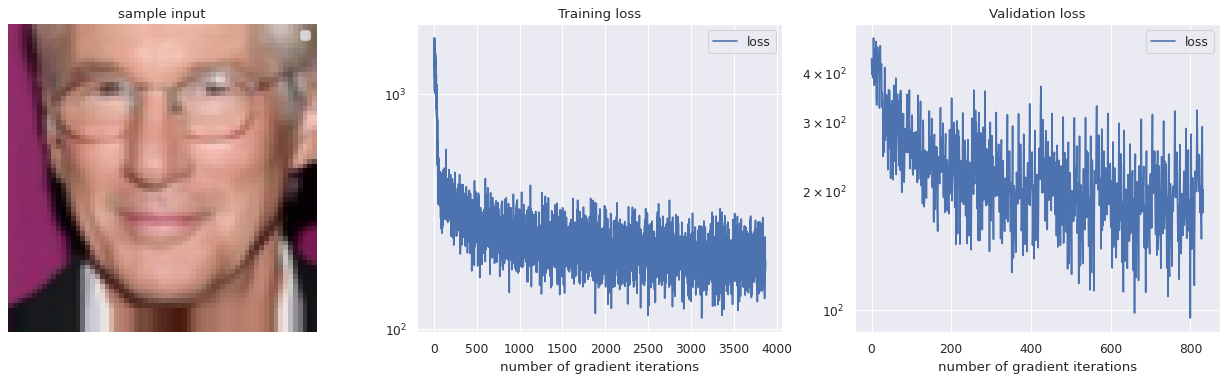

Validation epoch 29, iteration 20 of 28 (71 %), loss=201.5732


In [ ]:
#Code Sources from EECE571T Assignment3
import torch.optim as optim
from IPython import display

# prepare plotting
fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1,3)

optimizer = optim.Adam(network.parameters(), lr=0.0002)

num_epochs = 30
train_losses = []
val_losses = []

for e in range(num_epochs):
    train_iter = iter(train_iter)
    network.train()
    for i in range(len(train_iter)):        
        batch_cpu = next(train_iter)
        batch_gpu = move_to_cuda(batch_cpu)
        batch_dict = tuple_to_dict(batch_gpu)

        pred = network(batch_dict['image'])
        pred_cpu = dict_to_device(pred, 'cpu')

        
        # calculate the loss and backward the gradient
        loss = my_mse_loss(pred_cpu['age'], batch_dict['age'].cpu())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if i%100==0:            
            axes[0].cla()
            axes[1].cla()            

            # plot some sample image inputs 
            plot_images(torch.from_numpy(batch_cpu[0][0:1]), ax=axes[0])  
            axes[0].legend()
            axes[0].set_title('sample input')

            # plot the training error on a log plot
            axes[1].plot(train_losses, label='loss')
            axes[1].set_yscale('log')
            axes[1].set_title('Training loss')
            axes[1].set_xlabel('number of gradient iterations')
            axes[1].legend()
            # clear output window and display updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Training epoch {}, iteration {} of {} ({} %), loss={:0.4f}".format(e, i, len(train_iter), 100*i//len(train_iter), train_losses[-1]))

    val_iter = iter(val_iter)
    network.eval()    
    for i in range(len(val_iter)):
        batch_cpu = next(val_iter)
        batch_gpu = move_to_cuda(batch_cpu)
        batch_dict = tuple_to_dict(batch_gpu)

        pred = network(batch_dict['image'])
        pred_cpu = dict_to_device(pred, 'cpu')
        
        # calculate the loss
        with torch.no_grad():
            loss = my_mse_loss(pred_cpu['age'], batch_dict['age'].cpu())        
            val_losses.append(loss.item()) 

        if i%10==0: 
            axes[2].cla()            

            # plot the validation error on a log plot
            axes[2].plot(val_losses, label='loss')
            axes[2].set_yscale('log')
            axes[2].set_title('Validation loss')
            axes[2].set_xlabel('number of gradient iterations')
            axes[2].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Validation epoch {}, iteration {} of {} ({} %), loss={:0.4f}".format(e, i, len(val_iter), 100*i//len(val_iter), val_losses[-1]))            
plt.close('all')

In [ ]:
def get_accuracy(network, data_loader, threshold=0.5):
    network.eval()
    iterator = iter(data_loader)    
    correct = 0
    total = 0
    for i in range(len(iterator)):        
        batch_cpu = next(iterator)
        batch_gpu = move_to_cuda(batch_cpu)
        
        batch_dict = tuple_to_dict(batch_gpu)
        image = batch_dict['image']

        pred = network(image)  
        pred = pred['age'].squeeze() 
       
        ground_truth = batch_dict['age']
       
        accuracy = ((pred - ground_truth).abs() <= (threshold*ground_truth)).sum().item()     
        correct += accuracy       
        total += pred.shape[0]
     
    return correct / total

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
torch.save(network.state_dict(), '/content/drive/MyDrive/model_trans_age_V1.pth')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model = ViT().to('cuda')
model.load_state_dict(torch.load('/content/drive/MyDrive/model_trans_age_V1.pth'))

<All keys matched successfully>

In [ ]:
#30epoch
print("Train accuracy is: ", get_accuracy(model, train_iter))
print("Validation accuracy is: ", get_accuracy(model, val_iter))
print("Test accuracy is: ", get_accuracy(model, test_iter))

<ipython-input-8-c9d66da01852>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_dict['image'] = torch.tensor(batch_tuple[0])
<ipython-input-8-c9d66da01852>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_dict['age'] = torch.tensor(batch_tuple[1])


Train accuracy is:  0.363362458571859
Validation accuracy is:  0.3804836895388076
Test accuracy is:  0.3542310936182176


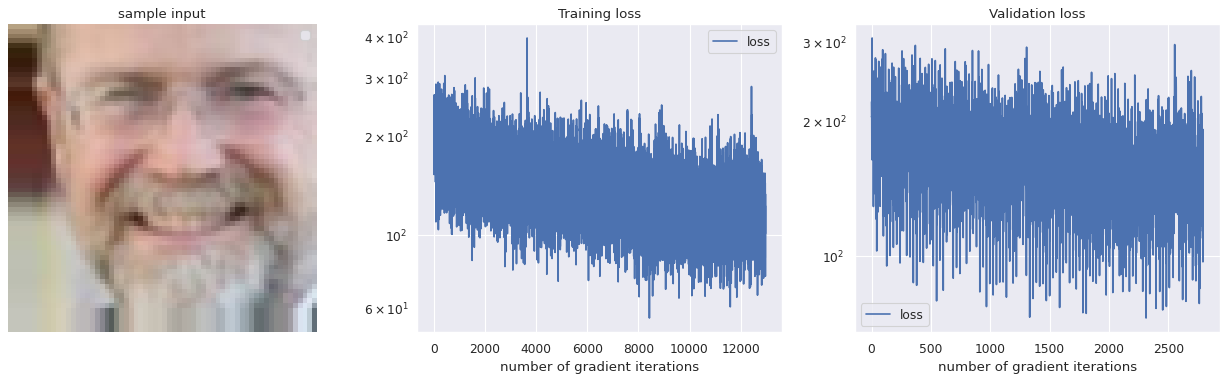

Validation epoch 99, iteration 20 of 28 (71 %), loss=125.0278


In [ ]:
#130epoch
#Code Cited from EECE571T Assignment3
import torch.optim as optim
from IPython import display

fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1,3)

optimizer = optim.Adam(model.parameters(), lr=0.0002)

num_epochs = 100
train_losses = []
val_losses = []

for e in range(num_epochs):
    train_iter = iter(train_iter)
    network.train()
    for i in range(len(train_iter)):        
        batch_cpu = next(train_iter)
        batch_gpu = move_to_cuda(batch_cpu)
        batch_dict = tuple_to_dict(batch_gpu)

        pred = model(batch_dict['image'])
        pred_cpu = dict_to_device(pred, 'cpu')

        
        # calculate the loss and backward the gradient
        loss = my_mse_loss(pred_cpu['age'], batch_dict['age'].cpu())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if i%100==0:            
            axes[0].cla()
            axes[1].cla()            

            # plot some sample image inputs 
            plot_images(torch.from_numpy(batch_cpu[0][0:1]), ax=axes[0])  
            axes[0].legend()
            axes[0].set_title('sample input')

            # plot the training error on a log plot
            axes[1].plot(train_losses, label='loss')
            axes[1].set_yscale('log')
            axes[1].set_title('Training loss')
            axes[1].set_xlabel('number of gradient iterations')
            axes[1].legend()
            # clear output window and display updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Training epoch {}, iteration {} of {} ({} %), loss={:0.4f}".format(e, i, len(train_iter), 100*i//len(train_iter), train_losses[-1]))

    val_iter = iter(val_iter)
    model.eval()    
    for i in range(len(val_iter)):
        batch_cpu = next(val_iter)
        batch_gpu = move_to_cuda(batch_cpu)
        batch_dict = tuple_to_dict(batch_gpu)

        pred = model(batch_dict['image'])
        pred_cpu = dict_to_device(pred, 'cpu')
        
        # calculate the loss
        with torch.no_grad():
            loss = my_mse_loss(pred_cpu['age'], batch_dict['age'].cpu())        
            val_losses.append(loss.item()) 

        if i%10==0: 
            axes[2].cla()            

            # plot the validation error on a log plot
            axes[2].plot(val_losses, label='loss')
            axes[2].set_yscale('log')
            axes[2].set_title('Validation loss')
            axes[2].set_xlabel('number of gradient iterations')
            axes[2].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Validation epoch {}, iteration {} of {} ({} %), loss={:0.4f}".format(e, i, len(val_iter), 100*i//len(val_iter), val_losses[-1]))            
plt.close('all')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
torch.save(model.state_dict(), '/content/drive/MyDrive/transformer_model_age_130epoch.pth')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model_new = ViT().to('cuda')
model_new.load_state_dict(torch.load('/content/drive/MyDrive/transformer_model_age_130epoch.pth'))

<All keys matched successfully>

In [ ]:
#130epoch
print("Train accuracy is: ", get_accuracy(model_new, train_iter))
print("Validation accuracy is: ", get_accuracy(model_new, val_iter))
print("Test accuracy is: ", get_accuracy(model_new, test_iter))

<ipython-input-8-c9d66da01852>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_dict['image'] = torch.tensor(batch_tuple[0])
<ipython-input-8-c9d66da01852>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_dict['age'] = torch.tensor(batch_tuple[1])


Train accuracy is:  0.8183790298282615
Validation accuracy is:  0.8354893138357705
Test accuracy is:  0.8189485521506887


In [ ]:
mt_train_data, mt_remain_data, mt_y_age_train, mt_y_age_remain = train_test_split(x, y_age, test_size=0.3, random_state=42)
mt_val_data, mt_test_data, mt_y_age_val, mt_y_age_test = train_test_split(mt_remain_data, mt_y_age_remain, test_size=0.5, random_state=42)

mt_train_data, mt_remain_data, mt_y_race_train, mt_y_race_remain = train_test_split(x, y_race, test_size=0.3, random_state=42)
mt_val_data, mt_test_data, mt_y_race_val, mt_y_race_test = train_test_split(mt_remain_data, mt_y_race_remain, test_size=0.5, random_state=42)

mt_train_data, mt_remain_data, mt_y_gender_train, mt_y_gender_remain = train_test_split(x, y_gender, test_size=0.3, random_state=42)
mt_val_data, mt_test_data, mt_y_gender_val, mt_y_gender_test = train_test_split(mt_remain_data, mt_y_gender_remain, test_size=0.5, random_state=42)

In [ ]:
# Concatenate age and race targets for training set
mt_y_train = np.concatenate([np.array(mt_y_age_train).reshape(-1, 1), np.array(mt_y_race_train).reshape(-1, 1), np.array(mt_y_gender_train).reshape(-1, 1)], axis=1)

mt_train_iter = train_datagen.flow(mt_train_data, mt_y_train, batch_size=128)

# Concatenate age and race targets for validation set
mt_y_val = np.concatenate([np.array(mt_y_age_val).reshape(-1, 1), np.array(mt_y_race_val).reshape(-1, 1), np.array(mt_y_gender_val).reshape(-1, 1)], axis=1)

# Create data generators for validation set with multiple targets
mt_val_iter = val_datagen.flow(mt_val_data, mt_y_val, batch_size=128)

# Concatenate age and race targets for test set
mt_y_test = np.concatenate([np.array(mt_y_age_test).reshape(-1, 1), np.array(mt_y_race_test).reshape(-1, 1), np.array(mt_y_gender_test).reshape(-1, 1)], axis=1)

# Create data generators for test set with multiple targets
mt_test_iter = test_datagen.flow(mt_test_data, mt_y_test, batch_size=128)

In [ ]:
#Code structure cited from EECE571T A3
# 3 types
from einops.layers.torch import Rearrange
class MultiViT(nn.Module):
    def __init__(self):
        super(MultiViT, self).__init__()
        
        num_layers=6;
        image_size=64;
        patch_size=12;
        num_classes=10;
        num_heads=8 

        hidden_dim=256;
        embedding_dim=256;
        drop_out_prob=0.2;

        num_patches = (image_size // patch_size) ** 2
        self.patch_embedding = nn.Sequential(
            nn.Conv2d(3, embedding_dim, kernel_size=patch_size, stride=patch_size),
            nn.BatchNorm2d(embedding_dim),
            nn.ReLU(),
            Rearrange('b c h w -> b (h w) c')
        )
        
        self.class_embedding_age = nn.Parameter(torch.randn(1, 1, embedding_dim))
        self.class_embedding_race = nn.Parameter(torch.randn(1, 1, embedding_dim))
        self.class_embedding_gender = nn.Parameter(torch.randn(1, 1, embedding_dim))

        self.positional_encoding = nn.Parameter(torch.randn(1, num_patches + 3, embedding_dim))
        self.dropout = nn.Dropout(drop_out_prob)

        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dim_feedforward=1024, dropout=drop_out_prob),
            num_layers=num_layers
        )

        self.to_cls_token = nn.Identity()
        self.mlp_head_age = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(drop_out_prob),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(drop_out_prob),
            nn.Linear(hidden_dim,1)
        )

        self.mlp_head_race = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(drop_out_prob),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(drop_out_prob),
            nn.Linear(hidden_dim, 5)
        )

        self.mlp_head_gender = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(drop_out_prob),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(drop_out_prob),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, input_dict):              
        x = input_dict
        x = input_dict.permute(0, 3, 1, 2)

        x = self.patch_embedding(x)
        class_em_age = self.class_embedding_age.expand(x.shape[0], -1, -1)
        class_em_gender = self.class_embedding_gender.expand(x.shape[0], -1, -1)
        class_em_race = self.class_embedding_race.expand(x.shape[0], -1, -1)

        x = torch.cat([class_em_age, class_em_race, class_em_gender, x], dim=1)

        x = x + self.positional_encoding
        x = self.dropout(x)

        x = x.permute(1, 0, 2)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)
        
        class_token_age = x[:, 0, :]
        class_token_race = x[:, -1, :]
        class_token_gender = x[:, -2, :]

        gender_logits_x = self.mlp_head_gender(class_token_gender)
        race_logits_x = self.mlp_head_race(class_token_race)

        age_pred = self.mlp_head_age(class_token_age)
        age_pred = age_pred.view(-1).float() 

        gender_pred = nn.functional.log_softmax(gender_logits_x, dim=1).float()
        race_pred = nn.functional.log_softmax(race_logits_x, dim=1).float()
       
        return {'age': age_pred, 'gender': gender_pred, 'race': race_pred }

network = MultiViT().to('cuda')

In [ ]:
def my_mse_loss(prediction, target):
    prediction=prediction.float()
    target=target.float()
    loss = nn.MSELoss()(prediction, target)   
    return loss

In [ ]:
def my_bce_loss(predicted_index, target_index):
  loss = nn.BCEWithLogitsLoss()(predicted_index, target_index)    
  return loss 

In [ ]:
def my_ce_loss(predicted_index, target_index):
  loss = nn.CrossEntropyLoss()(predicted_index, target_index.long())        
  return loss

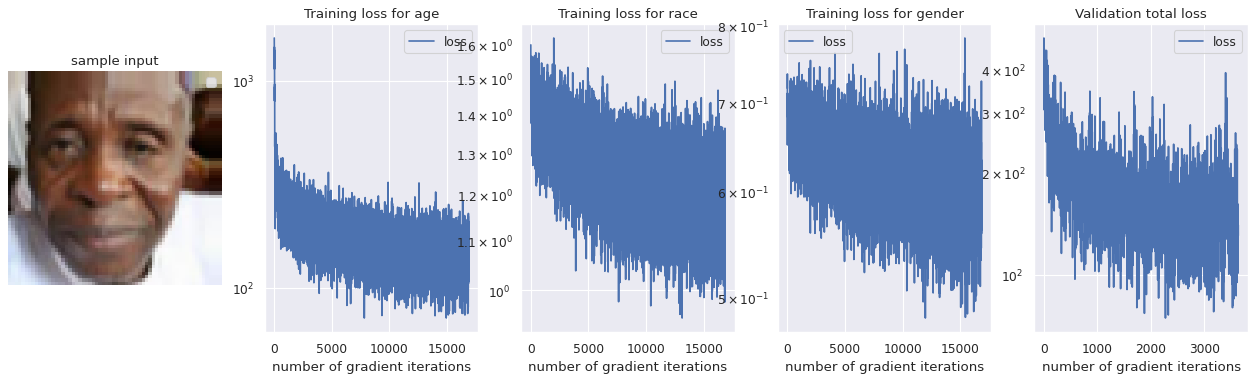

Validation epoch 129, iteration 20 of 28 (71 %), total_loss=130.4430


In [ ]:
# Code Cited from Assignment3 EECE571T
%matplotlib inline
from IPython import display

# prepare plotting
fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1,5)

optimizer = torch.optim.Adam(network.parameters(), lr=0.0002)

num_epochs = 130
train_losses_age = []
train_losses_race = []
train_losses_gender = []
val_losses = []

for e in range(num_epochs):
    train_iter = iter(mt_train_iter)
    network.train()
    for i in range(len(mt_train_iter)):        
        batch_cpu = next(mt_train_iter)
        y_value=np.transpose(batch_cpu[1])
        y_value=torch.tensor(y_value).cuda()


        batch_gpu = move_to_cuda(batch_cpu)
        batch_dict = tuple_to_dict_multitask(batch_gpu)
       
        pred = network(batch_dict['image'])
        pred_cpu = dict_to_device(pred, 'cpu')

        loss_age = my_mse_loss(pred['age'].float(), y_value[0].float())
        loss_race = my_ce_loss(pred['race'].float(), y_value[1].long())
        loss_gender = my_bce_loss(pred['gender'][:, 1], y_value[2].float())
        loss = loss_age + loss_race+loss_gender
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses_age.append(loss_age.item())  
        train_losses_race.append(loss_race.item())
        train_losses_gender.append(loss_gender.item())
        
        if i%100==0:            
            axes[0].cla()
            axes[1].cla()            
            axes[2].cla()
            axes[3].cla() 

            plot_images(torch.from_numpy(batch_cpu[0][0:1]), ax=axes[0])        
            axes[0].legend()
            axes[0].set_title('sample input')

            # plot the training error on a log plot for loss_age
            axes[1].plot(train_losses_age, label='loss')
            axes[1].set_yscale('log')
            axes[1].set_title('Training loss for age')
            axes[1].set_xlabel('number of gradient iterations')
            axes[1].legend()

            # plot the training error on a log plot for loss_race
            axes[2].plot(train_losses_race, label='loss')
            axes[2].set_yscale('log')
            axes[2].set_title('Training loss for race')
            axes[2].set_xlabel('number of gradient iterations')
            axes[2].legend()

            # plot the training error on a log plot for loss_gender
            axes[3].plot(train_losses_gender, label='loss')
            axes[3].set_yscale('log')
            axes[3].set_title('Training loss for gender')
            axes[3].set_xlabel('number of gradient iterations')
            axes[3].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Training epoch {}, iteration {} of {} ({} %), loss_age={:0.4f}, loss_race={:0.4f},  loss_gender={:0.4f}".
                  format(e, i, len(train_iter), 100*i//len(train_iter), train_losses_age[-1], train_losses_race[-1],  train_losses_gender[-1]))          

    val_iter = iter(mt_val_iter)
    network.eval()    
    for i in range(len(mt_val_iter)):
        batch_cpu = next(val_iter)
        y_value=np.transpose(batch_cpu[1])
        y_value=torch.tensor(y_value).cuda()


        batch_gpu = move_to_cuda(batch_cpu)
        batch_dict = tuple_to_dict_multitask(batch_gpu)

        pred = network(batch_dict['image'])
        pred_cpu = dict_to_device(pred, 'cpu')
        
        # calculate the loss
        with torch.no_grad():            
            loss_age = my_mse_loss(pred['age'].float(), y_value[0].float())
            loss_race = my_ce_loss(pred['race'].float(), y_value[1].long())
            loss_gender = my_bce_loss(pred['gender'][:, 1], y_value[1].float())
            loss = loss_age + loss_gender + loss_race
            val_losses.append(loss.item()) 

        if i%10==0: 
            axes[4].cla()            

            # plot the validation error on a log plot
            axes[4].plot(val_losses, label='loss')
            axes[4].set_yscale('log')
            axes[4].set_title('Validation total loss')
            axes[4].set_xlabel('number of gradient iterations')
            axes[4].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Validation epoch {}, iteration {} of {} ({} %), total_loss={:0.4f}".
                  format(e, i, len(mt_val_iter), 100*i//len(mt_val_iter), val_losses[-1]))            
plt.close('all')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
torch.save(network.state_dict(), '/content/drive/MyDrive/transformer_age_multitask_model.pth')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model_trans = MultiViT().to('cuda')
model_trans.load_state_dict(torch.load('/content/drive/MyDrive/transformer_age_multitask_model.pth'))

<All keys matched successfully>

In [ ]:
def get_mt_accuracy(network, data_loader, threshold=0.5):
    network.eval()
    iterator = iter(data_loader)    
    correct = 0
    total = 0
    for i in range(len(iterator)):        
        batch_cpu = next(iterator)
        batch_gpu = move_to_cuda(batch_cpu)
        batch_dict = tuple_to_dict_multitask(batch_gpu)
        image = batch_dict['image']
       
        pred = network(image)  # Assuming 'label' is the predicted output for age
        pred = pred['age'].squeeze()  # Squeeze to remove any extra dimensions
        ground_truth = batch_gpu[1]  # Assuming batch_gpu[1] contains ground truth ages
        # print(ground_truth.shape)

        # Calculate accuracy as percentage of predictions within threshold
        accuracy = ((pred - ground_truth).abs() <= (threshold*ground_truth)).sum().item()     
        correct += accuracy       
        total += pred.shape[0]
    
    return correct / total

In [ ]:
print("Train accuracy is: ", get_mt_accuracy(model_trans, train_iter))
print("Validation accuracy is: ", get_mt_accuracy(model_trans, val_iter))
print("Test accuracy is: ", get_mt_accuracy(model_trans, test_iter))

<ipython-input-8-c9d66da01852>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_dict['image'] = torch.tensor(batch_tuple[0])
<ipython-input-8-c9d66da01852>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_dict['age'] = torch.tensor(batch_tuple[1][0])
<ipython-input-8-c9d66da01852>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_dict['race'] = torch.tensor(batch_tuple[1][1])
<ipython-input-8-c9d66da01852>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceT

Train accuracy is:  0.8086170533293161
Validation accuracy is:  0.8236782902137233
Test accuracy is:  0.8040483553556368
